
# Demo: Generic Supervised Machine Learning Pipeline

This Jupyter notebook implements and explains the end-to-end machine learning pipeline discussed in Chapter 2 of the following the book:

Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly, 2017
(http://shop.oreilly.com/product/0636920052289.do)

For more information on the book above, or the Python code provided by the author, see:
https://github.com/ageron/handson-ml

This pipeline contains an embedded (publicly downloadable) data set of California housing data. The embedded data set contains 1990 median house values of California census block groups, and other information about these census block groups. This pipeline performs the following:

(1) some basic diagnostics on the embedded data set,

(2) randomly split the data set into training and testing sets,

(3) perform some basic visualization on the training set,

(4) train four regression models based on the training set so as to predict the median house value based on the rest of the variables.

The first three regression models are linear regression, regression trees and random forests as implemented in the Python library Scikit-Learn with default (hyper)parameters (hence no hyperparameter tuning). The last regression model is random forests with hyperparameters specified in a certain "grid" of prescribed hyperparameter configurations, where the hyperparameter tuning is carried out using 10-fold cross validation.

## Set up the pipeline environment

More specifically:

(1)  Load required Python modules and classes.

(2)  Define paths to the code and data directories.

In [23]:
# import required modules and classes

import os, sys, shutil, getpass
import pprint, logging, datetime
import stat

import numpy   as np
import pandas  as pd
import seaborn as sns

In [24]:
# Define path of the parent folder of this jupyter notebook, and the
# code and data directories relative to it. The code directory contains
# Python source code for custom-built Python modules, which we will
# import later. The data directory contains the data we will use to
# demonstrate this supervised machine learning pipeline.

dir_MASTER = ".."
dir_code   = os.path.join(dir_MASTER, "code")
dir_data   = os.path.join(dir_MASTER, "data")

In [25]:
# check dir_code has been set correctly, by displaying the Python
# source code files it contains

print(os.listdir(dir_code))

['__init__.py', '__pycache__', 'CategoricalEncoder.py', 'examineData.py', 'PipelinePreprocessHousingData.py', 'splitTrainTest.py', 'trainEvaluate.py', 'trainEvaluateGrid.py', 'visualizeData.py']



## The embedded data set: California 1990 "census block group" housing data

The data set we use is downloadable from the Internet:

https://github.com/ageron/handson-ml/tree/master/datasets/housing

https://www.kaggle.com/camnugent/california-housing-prices

It is a table with 10 columns and 20640 rows. Each row corresponds to a 1990 California census block group. One of the variables is median_house_value, which we will use as the response variable for the regression exercise below. The rest of the variables contain information about the census block groups, for example, geo-coordinates (longitude, latitude), population size, median income, etc. These will be used as predictor variables (features) in the regression exercise below. For more information about the embedded data set, refer to the two web pages cited above.


#### Basic diagnostics on the full data set

In [26]:
# Load California housing data into the data frame housingDF.

housingFILE = os.path.join(dir_data,'housing.csv')
housingDF   = pd.read_csv(housingFILE);

In [27]:
# Basic info on housingDF: number of rows and name and data type
# of each column.

housingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
# View the first several rows of housingDF.

housingDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


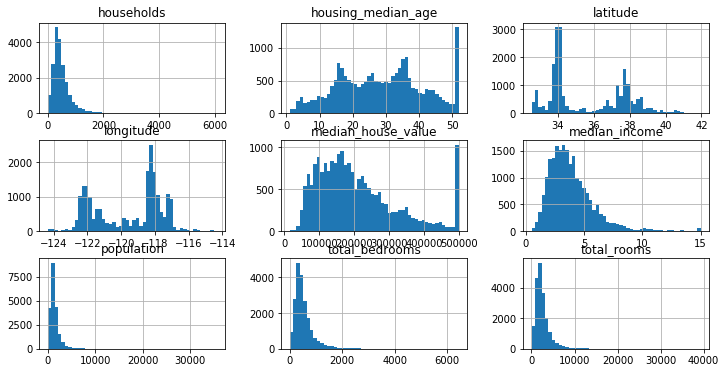

In [29]:
# histograms on the nine continuous variables

import matplotlib.pyplot as plt
myHistogram = housingDF.hist(bins = 50, figsize = (12,6))
plt.show()

## Split the full data set into training and testing sets.

In [30]:
# First, we add the code directory to the Python system path.
# (so that Python knows where to look for the source code of the
# custom built Python modules)

sys.path.append(dir_code)

In [31]:
# Next, we import the function splitTrainTest() from the custom built
# Python module splitTrainTest.
# We then split the full data set, housingDF, into training and testing
# sets using splitTrainTest().
# Note that the splitting is done in a stratified manner.
# The stratification is based income category (a derived variable from
# median_income).
# The splitting is required to preserve the distribution of income
# category.

from splitTrainTest import splitTrainTest
trainSet, testSet = splitTrainTest(inputDF = housingDF, random_state = 19)


income category relative sizes (whole data set)
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64


In [32]:
# Check the shapes of the training and testing data sets, and compare
# those with the original full data set.
# Note that the number of variables of housingDF is now 11 (instead of
# 10 as above) because, during the splitting process, we added the
# derived variable of income category for stratification.

print(housingDF.shape)
print(trainSet.shape)
print(testSet.shape)

(20640, 11)
(16512, 10)
(4128, 10)


In [33]:
# We check that housingDF now indeed has a new variable called
# income_category, which was added by splitTrainTest().

housingDF.info()
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
income_category       20640 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 8663 to 7054
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16336 non-null float64
populati

## Visualization of training set (we emphasize: we exclude the testing set in the visualization)

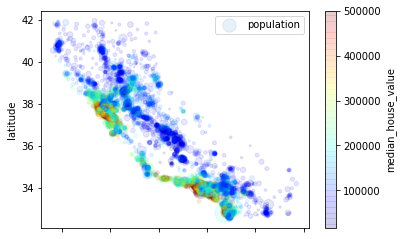

In [34]:
# Bubble Heat Map:
# (*)  Each bubble represents a California census block group.
# (*)  Horizontal and vertical coordinates are longitude and latitude,
#      respectively.
# (*)  Bubble size indicates population size.
# (*)  Bubble colour indicates median house value.

myPlot = trainSet.plot(
    label    = 'population',
    kind     = 'scatter',
    x        = 'longitude',
    y        = 'latitude',
    s        = housingDF["population"] / 100,
    c        = 'median_house_value',
    cmap     = plt.get_cmap("jet"),
    colorbar = True,
    alpha    = 0.1
    )
plt.show()

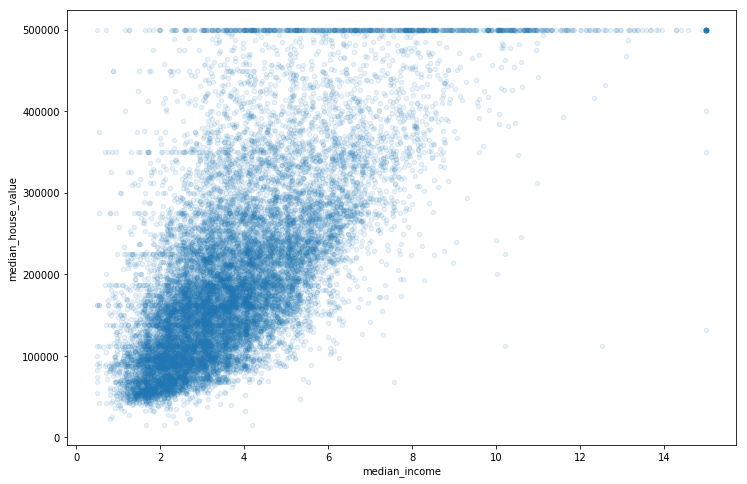

In [35]:
# Scatter plot of median house value (response variable) against
# median income. Note the rather strong correlation between these
# two variables.

myPlot = trainSet.plot(
    kind    = 'scatter',
    x       = "median_income",
    y       = "median_house_value",
    alpha   = 0.1,
    figsize = (12,8)
    )
plt.show()

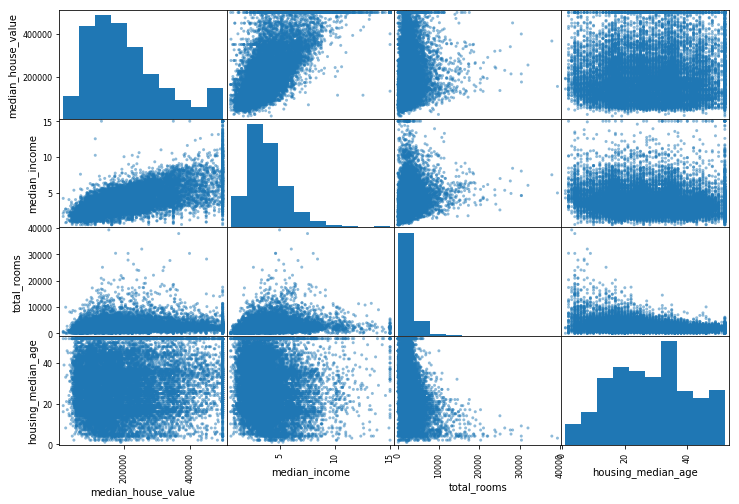

In [36]:
# Scatter plots and histograms for four of the continuous variables.

from pandas.plotting import scatter_matrix
corrMatrix = trainSet.corr()
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
myPlot = scatter_matrix(frame=trainSet[attributes], figsize=(12,8))
plt.show()

## Preprocessing

In [37]:
# The preprocessing includes the following tasks:
#  (1)  median imputation for continuous variables
#  (2)  add two derived variables: number of rooms per household,
#       population per household
#  (3)  binarize the categorical variable: ocean_proximity (replace
#       it with a collection of binary indicators)

# Note that the preprocessing here is done by fitting a data
# preprocessing sub-pipeline, which we call PipelinePreprocessHousingData.
# Note that the fitting is done only to the training subset. This fitted
# preprocessing sub-pipeline will be used as an input to the
# trainEvaluate() function below.

from PipelinePreprocessHousingData import PipelinePreprocessHousingData
preprocessedTrainSet = PipelinePreprocessHousingData.fit_transform(
    trainSet.drop(["median_house_value"],axis=1)
    )

In [38]:
# Take a look at the top three rows of the preprocessed training data.

print(type(preprocessedTrainSet))
preprocessedTrainSet[0:3,]

<class 'numpy.ndarray'>


array([[ 0.59311284, -0.84368509,  0.91777934,  0.19522684,  0.07694854,
        -0.14480532,  0.01372209,  0.68219324,  0.27712397, -0.09712907,
        -0.42595431,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.09212684, -1.13781385, -0.91562623, -0.35121612,  0.10330353,
        -0.12355599, -0.19581394, -1.01636674, -0.44156162,  0.00596612,
         1.46978359,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.29173244, -1.35257454, -0.91562623,  0.59509667,  0.73103156,
         0.5024137 ,  0.6947142 , -0.61817454, -0.12078124, -0.0762501 ,
         0.0045411 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

## Custom-built module: trainEvaluate.py

We now fit the three hyperparameter-free regression models: linear regression, regression trees, and random forest regression.

For each of these three models, we go through the same sequence of steps, namely:

(1)  preprocess the training data,

(2)  fit the model to the training data,

(3)  compute the training error,

(4)  compute the 10-fold cross validation error,

(5)  compute the testing error.

Due to this repetition, we implemented the trainEvaluate( ) function, which accepts the choice of regression model as an input, and executes the preceding steps for the given model.


In [39]:
########################################################
#
# source code for the Python module: trainEvaluate.py
#
########################################################

# import numpy as np
# from sklearn.metrics import mean_squared_error

# import importlib
# from importlib.util import find_spec
# ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
# if ms_spec is not None:
#     from sklearn.model_selection import cross_val_score
# else:
#     from sklearn.cross_validation import cross_val_score
#
# def trainEvaluate(trainData, testData, trainedPreprocessor, myModel, modelName):
#
#     preprocessedTrainData = trainedPreprocessor.transform(
#         trainData.drop(["median_house_value"],axis=1)
#         )
#
#     myModel.fit(X = preprocessedTrainData, y = trainData["median_house_value"])
#     myPredictions = myModel.predict(X = preprocessedTrainData)
#
#     myTrainMSE  = mean_squared_error(myPredictions,trainData["median_house_value"])
#     myTrainRMSE = np.sqrt(myTrainMSE)
#
#     ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
#     nFold =10
#
#     CVScores = cross_val_score(
#         estimator = myModel,
#         X         = preprocessedTrainData,
#         y         = trainData["median_house_value"],
#         scoring   = "neg_mean_squared_error",
#         cv        = nFold
#         )
#     CVRMSE = np.sqrt( - CVScores )
#
#     ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
#     preprocessedTestData = trainedPreprocessor.transform(
#         testData.drop(["median_house_value"],axis=1)
#         )
#
#     myPredictions = myModel.predict(X = preprocessedTestData)
#
#     myTestMSE  = mean_squared_error(myPredictions,testData["median_house_value"])
#     myTestRMSE = np.sqrt(myTestMSE)
#
#     ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
#     print("\n### ~~~~~~~~~~~~~~~~~~~~ ###")
#     print("###  " + modelName)
#
#     print("\nTrain RMSE: " + str(myTrainRMSE))
#
#     print("\nCV RMSE (" + str(nFold) + "-fold):")
#     print(CVRMSE)
#     print("\nCV RMSE (mean): " + str(CVRMSE.mean()) )
#     print("\nCV RMSE (std): "  + str(CVRMSE.std())  )
#
#     print("\nTest RMSE: " + str(myTestRMSE))
#
#     ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
#     return( None )
#


## trainEvaluate( LinearRegression )

In [40]:
# import the trainEvaluate() function from the custom-built trainEvaluate module

from trainEvaluate import trainEvaluate

In [41]:
# import Scikit-learn's LinearRegression classs
from sklearn.linear_model import LinearRegression

# instantiate a LinearRegression object
myLinearModel = LinearRegression()

# train and evaluate a linear model (this underfits the data)
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myLinearModel,
    modelName           = "Linear Model"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Linear Model

Train RMSE: 68205.5245154

CV RMSE (10-fold):
[ 71213.42875203  69374.24757249  69744.15111082  67634.72605826
  67556.95118003  70447.0948898   66602.78109188  67053.6825131
  69152.900413    68090.74548673]

CV RMSE (mean): 68687.0709068

CV RMSE (std): 1450.490324

Test RMSE: 68763.2267712


## trainEvaluate( RegressionTree )

In [42]:
# regression tree (this overfits the data: zero MSE on training data)

from sklearn.tree import DecisionTreeRegressor
myRegressionTreeModel = DecisionTreeRegressor()
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myRegressionTreeModel,
    modelName           = "Regression Tree"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Regression Tree

Train RMSE: 0.0

CV RMSE (10-fold):
[ 71271.84020167  72789.69603897  71725.41452374  70667.08396297
  68858.97853975  70904.58819292  73176.27297668  74658.38632559
  63581.05206067  68602.67949721]

CV RMSE (mean): 70623.599232

CV RMSE (std): 2932.54425281

Test RMSE: 70583.364907


## trainEvaluate( RandomForest )

In [43]:
# random forest

from sklearn.ensemble import RandomForestRegressor
myRandomForestModel = RandomForestRegressor()
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myRandomForestModel,
    modelName           = "Random Forest"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Random Forest

Train RMSE: 22352.7093118

CV RMSE (10-fold):
[ 52082.01574638  53033.50002868  54545.15758864  51682.31162482
  51254.12105368  55657.87253162  53861.03383641  51958.4531951
  48450.43709231  53106.28423939]

CV RMSE (mean): 52563.1186937

CV RMSE (std): 1889.63956632

Test RMSE: 52792.185601



## trainEvaluateGrid( RandomForest )

We now fit the fourth and last regression model: random forests regression model with hyperparameters.

The trainEvaluateGrid( ) function from the custom-built module trainEvaluateGrid is an extension of
the eariler trainEvaluate( ) function, where trainEvaluateGrid() accepts a GridSearchCV object as an additional input that specifies the "grid" of hyperparameter configurations on which to search for an optimal (in the sense of minimizing the cross validation error) hyperparameter configuration via cross validation.

In [44]:
# import the trainEvaluateGrid() function from the custom-built
# module trainEvaluateGrid
from trainEvaluateGrid import trainEvaluateGrid

# random forest with hyperparameter tuning via grid search
import importlib
from importlib.util import find_spec

ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
if ms_spec is not None:
    from sklearn.model_selection import GridSearchCV
else:
    from sklearn.grid_search import GridSearchCV

# instantiate random forest regressor
from sklearn.ensemble import RandomForestRegressor
newRandomForestModel = RandomForestRegressor()

# define the hyperparameter grid (on which to search for the optimal
# hyperparameter configuration)
parameterGrid = [
    { 'n_estimators':[3,10,30], 'max_features':[2,4,6,8]                     },
    { 'n_estimators':[3,10],    'max_features':[2,3,4],  'bootstrap':[False] }
    ]

# instantiate a GridSearchCV object
gridSearch = GridSearchCV(
    estimator  = newRandomForestModel,
    param_grid = parameterGrid,
    scoring    = "neg_mean_squared_error",
    cv         = 5
    )

trainEvaluateGrid(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = gridSearch,
    modelName           = "Random Forest, Cross Validation, Grid Search"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Random Forest, Cross Validation, Grid Search

Train RMSE: 19622.5995235

(Cross Validation, Grid Search) RSME:
63881.9303154 {'max_features': 2, 'n_estimators': 3}
55339.442889 {'max_features': 2, 'n_estimators': 10}
52882.7905722 {'max_features': 2, 'n_estimators': 30}
60542.7158441 {'max_features': 4, 'n_estimators': 3}
52347.8237227 {'max_features': 4, 'n_estimators': 10}
50240.1303784 {'max_features': 4, 'n_estimators': 30}
58296.230306 {'max_features': 6, 'n_estimators': 3}
52026.5196596 {'max_features': 6, 'n_estimators': 10}
50167.9050687 {'max_features': 6, 'n_estimators': 30}
58621.0611065 {'max_features': 8, 'n_estimators': 3}
52238.4549283 {'max_features': 8, 'n_estimators': 10}
50314.3063095 {'max_features': 8, 'n_estimators': 30}
61337.882734 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54074.1630271 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59885.9697555 {'bootstrap': False, 'max_features': 3, 'n_estimator